In [315]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np
np.random.seed(1234)
sns.set(rc={'figure.figsize': (11.7, 8.27)})

import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                             accuracy_score, precision_score, recall_score,
                             f1_score, make_scorer) 

In [221]:
def metric_table(actual:pd.Series, model_names: list=None, *args)->pd.DataFrame:
    metrics = {
        'Fraud Detection Rate @ 3%': [],
        'False Negative Rate': [],
        'Accuracy': [],
        'AUC': [],
        'F1': [],
        'Precision': [],
        'Recall': []
    }
    
    for preds in args:
        arg = np.sort(np.array([x[0]-x[1] for x in preds]))[:int(0.03*len(actual))]
        arg = np.where(arg<=0, 1, 0)
        metrics['Fraud Detection Rate @ 3%'].append(sum(arg)/sum(actual))
                    
        preds = [np.argmax(x) for x in preds]
        
        temp = pd.DataFrame(preds, actual.values).reset_index()
        temp.columns = ['actual', 'preds']
        metrics['False Negative Rate'].append(len(temp[(temp['preds']==1)&(temp['actual']==0)])/\
                                                 (len(temp[(temp['preds']==1)&(temp['actual']==0)])+len(temp[(temp['preds']==0)&(temp['actual']==0)])))
        metrics['Accuracy'].append(accuracy_score(actual, preds))
        metrics['AUC'].append(roc_auc_score(actual, preds))
        metrics['Precision'].append(precision_score(actual, preds))
        metrics['Recall'].append(recall_score(actual, preds))
        metrics['F1'].append(f1_score(actual, preds))
    
    res = pd.DataFrame.from_dict(metrics)
    if model_names is not None:
        res.index = model_names
    
    return res

### Load Data

In [222]:
train = pd.read_csv('train.csv')

oot = pd.read_csv('oot.csv')

### Split into train/test

In [223]:
X = train.iloc[:, 1:25]
y = train.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.30)

In [250]:
X_oot = oot.iloc[:, 1:25]
y_oot = oot.iloc[:, 0]

### Logistic Regression (No Weights)

In [224]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

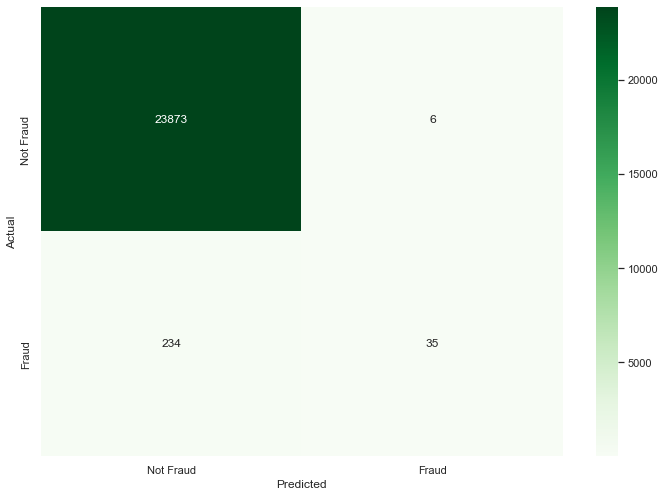

In [225]:
lr_preds = lr.predict_proba(X_test)

cm = confusion_matrix(y_test, [np.argmax(x) for x in lr_preds])

ax = plt.subplot()
sns.heatmap(cm, 
            annot=True, fmt='g', cmap='Greens',
            ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud'])
plt.show()

### Logistic Regression with Weights - Use Sklearn Class

In [226]:
weights = compute_sample_weight('balanced', y=y_train)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train, sample_weight=weights)

LogisticRegression(max_iter=1000)

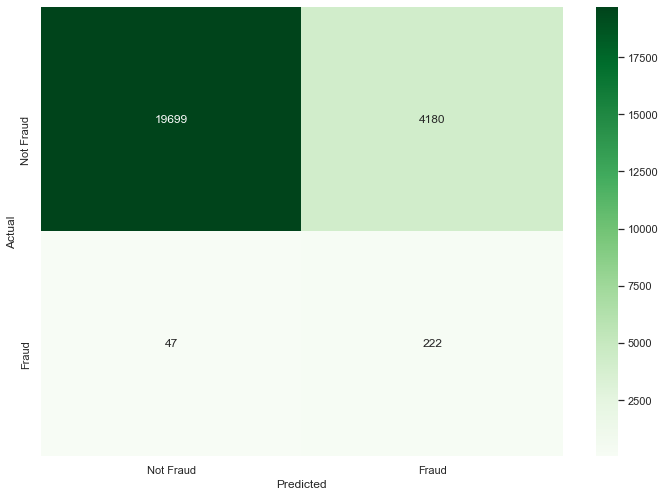

In [227]:
lr_preds_weight = lr.predict_proba(X_test)

cm_lr_weights = confusion_matrix(y_test, [np.argmax(x) for x in lr_preds_weight])

ax = plt.subplot()
sns.heatmap(cm_lr_weights, 
            annot=True, fmt='g', cmap='Greens',
            ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud'])
plt.show()

In [228]:
sum([np.argmax(x) for x in lr_preds_weight])

4402

### Logistic Regression with Weights - Use Custom Weights

In [229]:
weights = {1: 1.,
           0: 10.}

sgd = SGDClassifier(loss='log', class_weight=weights)
sgd.fit(X_train, y_train)

SGDClassifier(class_weight={0: 10.0, 1: 1.0}, loss='log')

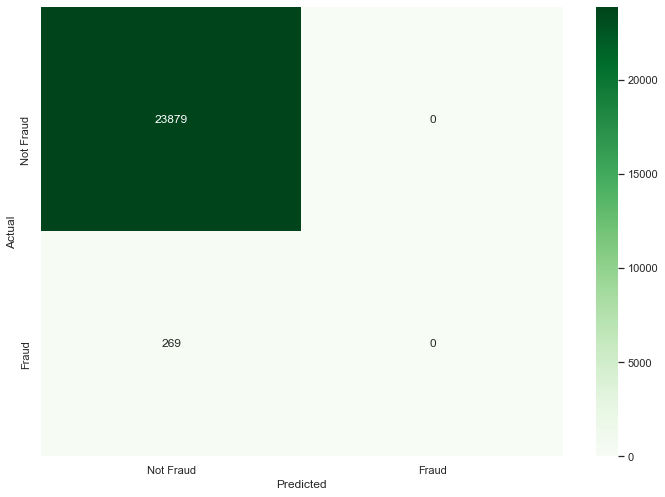

In [230]:
sgd_preds = sgd.predict_proba(X_test)

cm_sgd = confusion_matrix(y_test, [np.argmax(x) for x in sgd_preds])

ax = plt.subplot()
sns.heatmap(cm_sgd, 
            annot=True, fmt='g', cmap='Greens',
            ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud'])
plt.show()

In [231]:
cw = compute_class_weight('balanced', y_train.unique(), y_train)
weights = {1: cw.flat[0],
           0: cw.flat[1]}

sgd = SGDClassifier(loss='log', class_weight=weights)
sgd.fit(X_train, y_train)

SGDClassifier(class_weight={0: 47.11120401337793, 1: 0.5053635173193176},
              loss='log')

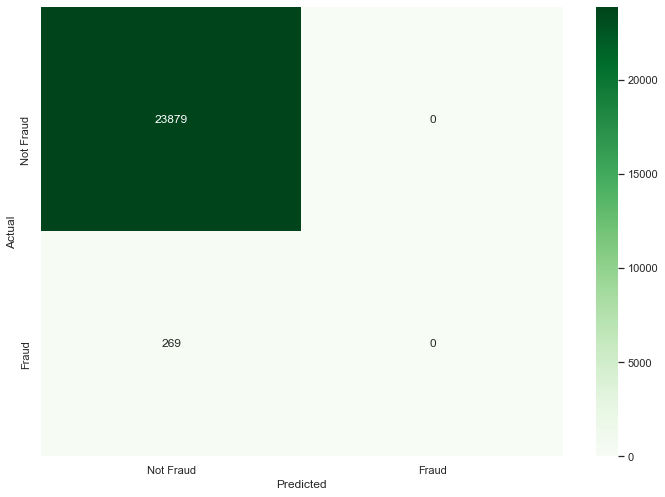

In [232]:
sgd_preds_sk = sgd.predict_proba(X_test)

cm_sgd_sk = confusion_matrix(y_test, [np.argmax(x) for x in sgd_preds_sk])

ax = plt.subplot()
sns.heatmap(cm_sgd_sk, 
            annot=True, fmt='g', cmap='Greens',
            ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud'])
plt.show()

### From the Results above, the SGD classifier using weights 1:10 and the base logistic regression provide the best results. Some more metrics can be shown below

In [233]:
tab = metric_table(y_test, ['Logistic Regression', 'Logistic Regression Weights', 'SGD', 'SGD Weights'],
                   lr_preds, lr_preds_weight, sgd_preds, sgd_preds_sk)
tab.style.set_caption('Logistic Regression and SGD Results on Test Set')

C:\Users\Alex\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Fraud Detection Rate @ 3%,False Negative Rate,Accuracy,AUC,F1,Precision,Recall
Logistic Regression,0.152416,0.000251,0.990061,0.564930,0.225806,0.853659,0.130112
Logistic Regression Weights,2.691450,0.175049,0.824954,0.825115,0.095055,0.050432,0.825279
SGD,0.000000,0.000000,0.988860,0.500000,0.000000,0.000000,0.000000
SGD Weights,0.000000,0.000000,0.988860,0.500000,0.000000,0.000000,0.000000


From the table above, the SGD achieves a significantly higher AUC score, so we will move forward with that model

### SVM

In [234]:
svm = SVC(probability=True)

svm.fit(X_train, y_train)

SVC(probability=True)

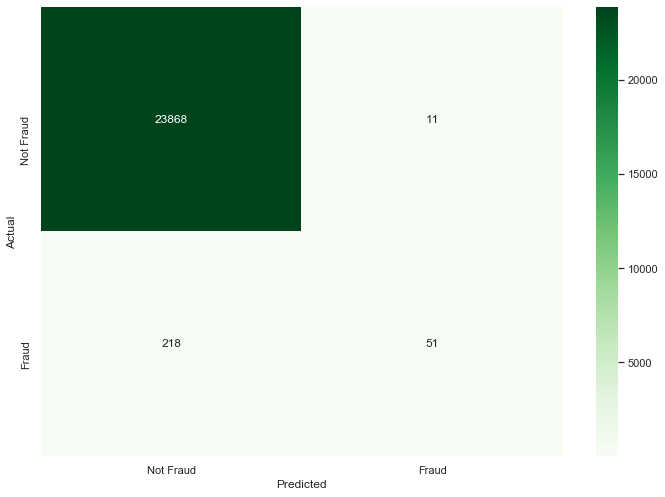

In [235]:
svm_preds = svm.predict_proba(X_test)

svm_cm = confusion_matrix(y_test, [np.argmax(x) for x in svm_preds])

ax = plt.subplot()
sns.heatmap(svm_cm,  
            annot=True, fmt='g', cmap='Greens',
            ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud'])
plt.show()

### SVM - Weights

In [236]:
weights = {0: 1.,
           1: 10.}

svm = SVC(class_weight=weights, probability=True)

svm.fit(X_train, y_train)

SVC(class_weight={0: 1.0, 1: 10.0}, probability=True)

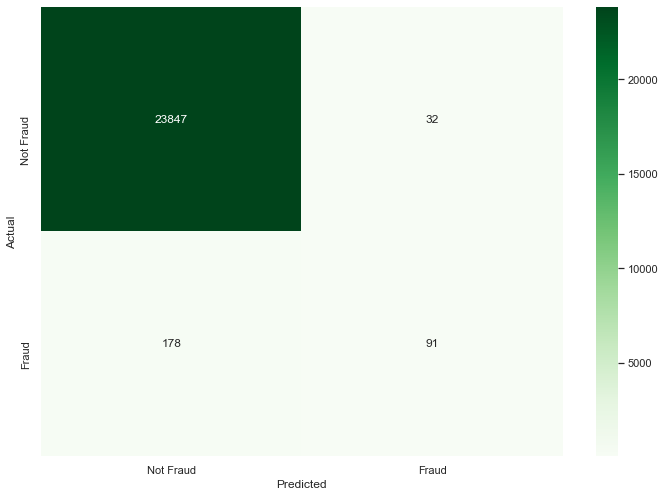

In [237]:
svm_preds_w = svm.predict_proba(X_test)

svm_cm_w = confusion_matrix(y_test, [np.argmax(x) for x in svm_preds_w])

ax = plt.subplot()
sns.heatmap(svm_cm_w,  
            annot=True, fmt='g', cmap='Greens',
            ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud'])
plt.show()

In [246]:
tab = metric_table(y_test, ['Logistic Regression', 'SGD', 'SVM No Weights', 'SVM Weights'], 
                   lr_preds, sgd_preds, svm_preds, svm_preds_w)
tab.style.set_caption('Logistic Regression and SVM Results on Test Set')

C:\Users\Alex\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Fraud Detection Rate @ 3%,False Negative Rate,Accuracy,AUC,F1,Precision,Recall
Logistic Regression,0.152416,0.000251,0.990061,0.564930,0.225806,0.853659,0.130112
SGD,0.000000,0.000000,0.988860,0.500000,0.000000,0.000000,0.000000
SVM No Weights,0.230483,0.000461,0.990517,0.594565,0.308157,0.822581,0.189591
SVM Weights,0.468401,0.001340,0.991304,0.668475,0.464286,0.739837,0.338290


This iteration of training tells us that SVM performs the best

### XGBoost

In [239]:
model = xgb.XGBClassifier(scale_pos_weight=np.sqrt((y_train==0).sum()/(y_train==1).sum()),
                          objective='binary:logistic', 
                          n_estimators=1000, 
                          max_depth=4,
                          base_score=0.5)

model.fit(X_train, y_train)

KeyError: 'base_score'

KeyError: 'base_score'

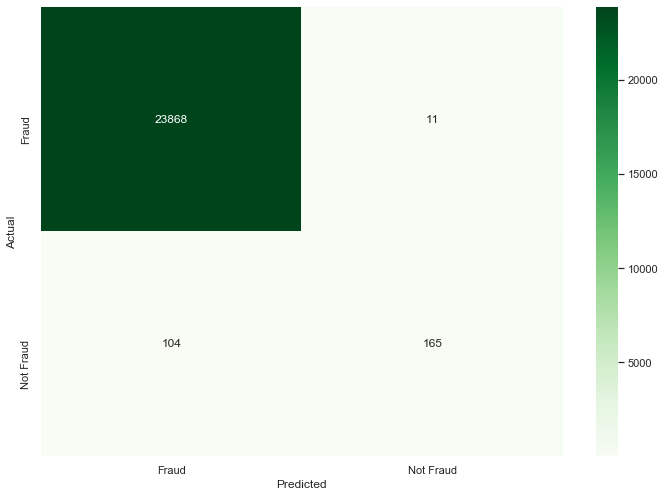

In [240]:
xgb_preds = model.predict_proba(X_test)

xgb_cm = confusion_matrix(y_test, [np.argmax(x) for x in xgb_preds])

ax = plt.subplot()
sns.heatmap(xgb_cm,  
            annot=True, fmt='g', cmap='Greens',
            ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['Fraud', 'Not Fraud'])
ax.yaxis.set_ticklabels(['Fraud', 'Not Fraud'])
plt.show()

In [247]:
tab = metric_table(y_test, ['SGD', 'SVM Weights', 'XGB'], 
                   sgd_preds, svm_preds_w, xgb_preds)
tab.style.set_caption('SVM and XGB Results on Test Set')

C:\Users\Alex\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Fraud Detection Rate @ 3%,False Negative Rate,Accuracy,AUC,F1,Precision,Recall
SGD,0.000000,0.000000,0.988860,0.500000,0.000000,0.000000,0.000000
SVM Weights,0.468401,0.001340,0.991304,0.668475,0.464286,0.739837,0.338290
XGB,0.654275,0.000461,0.995238,0.806461,0.741573,0.937500,0.613383


### Random Forest - no weights

In [242]:
rf = RandomForestClassifier(max_depth=10)

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10)

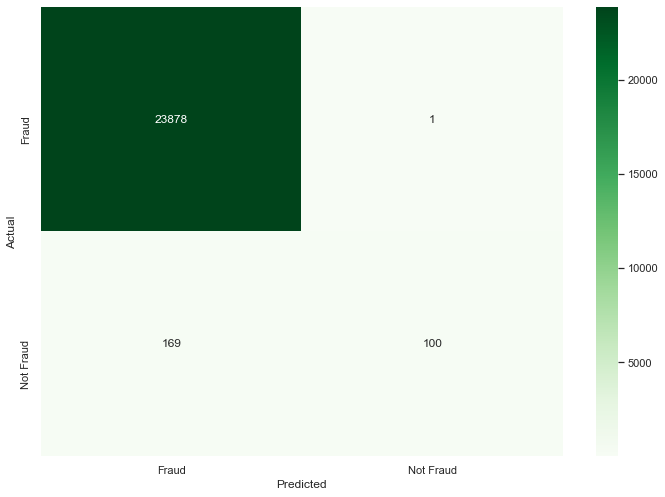

In [243]:
rf_preds = rf.predict_proba(X_test)

rf_cm = confusion_matrix(y_test, [np.argmax(x) for x in rf_preds])

ax = plt.subplot()
sns.heatmap(rf_cm,  
            annot=True, fmt='g', cmap='Greens',
            ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['Fraud', 'Not Fraud'])
ax.yaxis.set_ticklabels(['Fraud', 'Not Fraud'])
plt.show()

In [248]:
tab = metric_table(y_test, ['Logistic Regression', 'SVM Weights', 'XGB', 'RF'], 
                   lr_preds, svm_preds_w, xgb_preds, rf_preds)
tab.style.set_caption('LR, SVM, XGB and RF Results on Test Set')

,Fraud Detection Rate @ 3%,False Negative Rate,Accuracy,AUC,F1,Precision,Recall
Logistic Regression,0.152416,0.000251,0.990061,0.564930,0.225806,0.853659,0.130112
SVM Weights,0.468401,0.001340,0.991304,0.668475,0.464286,0.739837,0.338290
XGB,0.654275,0.000461,0.995238,0.806461,0.741573,0.937500,0.613383
RF,0.375465,0.000042,0.992960,0.685853,0.540541,0.990099,0.371747


# CV

## Take 4 models above, perform 10 fold CV on them

In [384]:
def fdr_score(y_true, y_pred):
    # arg = np.sort(np.array([x.flat[0]-x.flat[1] for x in y_pred]))[:int(0.03*len(y_pred))]
    # arg = np.where(arg<=0, 1, 0)
    
    # return sum(arg)/sum(y_true)
    res_df = pd.DataFrame(list(zip(y_true.values, [x.flat[1] for x in y_pred])), columns=['Fraud Actual', 'Fraud Score'])
    res_df = res_df.sort_values('Fraud Score',ascending=False)
    total_bads = sum(y_true)
    pop_3perc = int(round(len(res_df)*0.03))
    temp = res_df.head(pop_3perc)
    return round(sum(temp['Fraud Actual'])/total_bads,3)

In [385]:
def fdr_cross_val(model, X, y, scoring=scoring, cv=10):
    scores = cross_validate(model, X, y, return_estimator=True, n_jobs=-1)
    return fdr_score(y, scores['estimator'][0].predict_proba(X))

### Logistic Regression - 1

In [386]:
lr_cv_res = {
    'train': [],
    'test': [],
    'oot': []
}

In [387]:
for x in [10, 1, 0.1, 0.01, 0.001, 0.0001]:
    lr = LogisticRegression(max_iter=1000, C=x)
    
    lr_cv_res['train'].append(fdr_cross_val(lr1, X_train, y_train))
    lr_cv_res['test'].append(fdr_cross_val(lr1, X_test, y_test))
    lr_cv_res['oot'].append(fdr_cross_val(lr1, X_oot, y_oot))

In [388]:
lr_cv_res

{'train': [0.457, 0.457, 0.457, 0.457, 0.457, 0.457],
 'test': [0.498, 0.498, 0.498, 0.498, 0.498, 0.498],
 'oot': [0.385, 0.385, 0.385, 0.385, 0.385, 0.385]}

### SVM

In [389]:
svm_cv_res = {
    'train': [],
    'test': [],
    'oot': []
}

In [390]:
weights = {0: 1.,
           1: 10.}

for d in [3, 4]:
    for x in [10, 1, 0.1, 0.01, 0.001, 0.0001]:
        svm = SVC(C=x, degree=d, 
                  class_weight=weights, probability=True)

        svm_cv_res['train'].append(fdr_cross_val(svm, X_train, y_train))
        svm_cv_res['test'].append(fdr_cross_val(svm, X_test, y_test))
        svm_cv_res['oot'].append(fdr_cross_val(svm, X_oot, y_oot))

In [391]:
svm_cv_res

{'train': [0.808,
  0.711,
  0.543,
  0.48,
  0.44,
  0.441,
  0.808,
  0.711,
  0.543,
  0.48,
  0.44,
  0.441],
 'test': [0.77,
  0.673,
  0.532,
  0.483,
  0.48,
  0.476,
  0.77,
  0.673,
  0.532,
  0.483,
  0.48,
  0.476],
 'oot': [0.754,
  0.709,
  0.531,
  0.291,
  0.285,
  0.279,
  0.754,
  0.709,
  0.531,
  0.291,
  0.285,
  0.279]}

### XGB

In [392]:
xgb_cv_res = {
    'train': [],
    'test': [],
    'oot': []
}

In [393]:
for e in [600, 1000, 1400]:
    for d in [3, 4, 5]:
        xgb1 = xgb.XGBClassifier(scale_pos_weight=np.sqrt((y_train==0).sum()/(y_train==1).sum()),
                                    objective='binary:logistic', 
                                    n_estimators=e, 
                                    max_depth=d,
                                    base_score=0.5)
        
        xgb_cv_res['train'].append(fdr_cross_val(xgb1, X_train, y_train))
        xgb_cv_res['test'].append(fdr_cross_val(xgb1, X_test, y_test))
        xgb_cv_res['oot'].append(fdr_cross_val(xgb1, X_oot, y_oot))

In [394]:
xgb_cv_res

{'train': [0.957, 0.96, 0.958, 0.958, 0.96, 0.957, 0.96, 0.958, 0.957],
 'test': [0.959, 0.959, 0.959, 0.959, 0.959, 0.959, 0.959, 0.959, 0.959],
 'oot': [0.844, 0.844, 0.838, 0.844, 0.844, 0.838, 0.844, 0.844, 0.838]}

### RF

In [395]:
rf_cv_res = {
    'train': [],
    'test': [],
    'oot': []
}

In [396]:
weights = {0: 1.,
           1: 10.}

for m in ['sqrt', 'log2']:
    for e in [300, 400, 500, 600]:
        for d in [8, 9, 10]:
            rf = RandomForestClassifier(max_features=m,
                                        n_estimators=e,
                                        max_depth=d, 
                                        class_weight=weights)

            rf_cv_res['train'].append(fdr_cross_val(rf, X_train, y_train))
            rf_cv_res['test'].append(fdr_cross_val(rf, X_test, y_test))
            rf_cv_res['oot'].append(fdr_cross_val(rf, X_oot, y_oot))

In [397]:
rf_cv_res

{'train': [0.878,
  0.918,
  0.938,
  0.865,
  0.916,
  0.94,
  0.871,
  0.916,
  0.943,
  0.868,
  0.915,
  0.941,
  0.868,
  0.918,
  0.936,
  0.871,
  0.92,
  0.941,
  0.865,
  0.915,
  0.941,
  0.871,
  0.918,
  0.935],
 'test': [0.918,
  0.941,
  0.959,
  0.911,
  0.948,
  0.955,
  0.918,
  0.955,
  0.952,
  0.911,
  0.952,
  0.959,
  0.914,
  0.941,
  0.955,
  0.918,
  0.948,
  0.955,
  0.911,
  0.944,
  0.955,
  0.907,
  0.952,
  0.955],
 'oot': [0.844,
  0.844,
  0.844,
  0.844,
  0.844,
  0.844,
  0.844,
  0.844,
  0.844,
  0.844,
  0.844,
  0.844,
  0.844,
  0.844,
  0.844,
  0.844,
  0.844,
  0.844,
  0.844,
  0.844,
  0.844,
  0.844,
  0.844,
  0.844]}